# Graph Embedding Quality Evaluation

This notebook evaluates the quality of trained graph embeddings using metrics that are **independent of training noise level**.

## Metrics Computed
1. **Clustering Quality** - Silhouette, Calinski-Harabasz, Davies-Bouldin scores
2. **Nearest Neighbor Consistency** - Stability under augmentation
3. **Embedding Space Analysis** - Distribution statistics, uniformity
4. **Visualizations** - t-SNE, PCA, similarity distributions

In [1]:
import sys
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Setup paths
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'Notebooks' else NOTEBOOK_DIR
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/tmuehlen/repos/graph_coverage


In [2]:
# Import graph embedding modules
from graph_creator.graph_embeddings_v2 import (
    GraphDataset,
    TrainableGraphGINE,
    augment_graph,
    get_feature_dimensions,
)

from graph_creator.graph_embedding_evaluation import (
    compute_embeddings,
    nearest_neighbor_consistency,
    clustering_quality,
    embedding_space_analysis,
    plot_embedding_visualization,
    plot_similarity_distribution,
    plot_clustering_metrics,
    compare_models,
    print_comparison_summary,
)

# PyG imports
try:
    from torch_geometric.loader import DataLoader
except ImportError:
    from torch_geometric.data import DataLoader

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

print("All imports successful!")

All imports successful!


## 1. Configuration

Set up the checkpoint paths and sample size for evaluation.

In [3]:
# Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Sample size for evaluation (adjust based on available memory)
SAMPLE_SIZE = 10000

# Data paths
CARLA_PATTERN = str(PROJECT_ROOT / "actor_graphs/carla_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/*.pkl")
ARGOVERSE_PATTERN = str(PROJECT_ROOT / "actor_graphs/argoverse_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/*.pkl")

# List available checkpoints
checkpoint_dir = PROJECT_ROOT / "checkpoints"
available_runs = sorted([d for d in checkpoint_dir.iterdir() if d.is_dir()], reverse=True)
print(f"\nAvailable training runs (most recent first):")
for run in available_runs[:10]:
    print(f"  - {run.name}")

Using device: cuda

Available training runs (most recent first):
  - 20260106_222347
  - 20260106_222014
  - 20260106_213317
  - 20260104_162201
  - 20260103_234045
  - 20260103_122149
  - 20260103_010047
  - 20260103_005911
  - 20260102_182538
  - 20251129_101133


In [4]:
# Select checkpoint(s) to evaluate
# Modify these paths to point to your trained models

# Option 1: Evaluate the most recent run
CHECKPOINT_PATH = None  # Will be set below

# Option 2: Compare multiple runs (uncomment and modify)
# CHECKPOINTS_TO_COMPARE = {
#     'tuned_config': 'checkpoints/20260104_162201/checkpoint_loop5_epoch4.pt',
#     'large_config': 'checkpoints/20260103_234045/checkpoint_loop9_epoch9.pt',
# }

# Auto-select most recent checkpoint from most recent run
if available_runs:
    latest_run = available_runs[0]
    checkpoints = sorted(latest_run.glob("checkpoint_*.pt"), reverse=True)
    if checkpoints:
        CHECKPOINT_PATH = str(checkpoints[0])
        print(f"Selected checkpoint: {CHECKPOINT_PATH}")
    else:
        print("No checkpoints found in the latest run!")
else:
    print("No training runs found!")

Selected checkpoint: /home/tmuehlen/repos/graph_coverage/checkpoints/20260106_222347/checkpoint_loop0_epoch0.pt


## 2. Load Data

Load a random sample of graphs for evaluation.

In [5]:
# Load graph paths
print("Loading graph paths...")
graph_paths = glob.glob(CARLA_PATTERN) + glob.glob(ARGOVERSE_PATTERN)
print(f"Total graphs available: {len(graph_paths)}")

# Random sample for evaluation
np.random.seed(42)
if len(graph_paths) > SAMPLE_SIZE:
    sample_indices = np.random.choice(len(graph_paths), SAMPLE_SIZE, replace=False)
    sampled_paths = [graph_paths[i] for i in sample_indices]
else:
    sampled_paths = graph_paths

print(f"Sampled {len(sampled_paths)} graphs for evaluation")

# Create dataset and dataloader
eval_dataset = GraphDataset(sampled_paths)
eval_loader = DataLoader(eval_dataset, batch_size=256, shuffle=False)
print(f"Created DataLoader with {len(eval_loader)} batches")

Loading graph paths...
Total graphs available: 487123
Sampled 10000 graphs for evaluation
Created DataLoader with 40 batches


## 3. Load Model

Load the trained model from checkpoint.

In [6]:
def load_model_from_checkpoint(checkpoint_path, device='cuda'):
    """Load model from checkpoint file."""
    import json
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Try to load config from same directory
    config_path = Path(checkpoint_path).parent / "config.json"
    if config_path.exists():
        with open(config_path) as f:
            config = json.load(f)
        
        embedding_dim = config['model'].get('embedding_dim', config['model'].get('output_dim', 128))
        hidden_dim = config['model']['hidden_dim']
        num_layers = config['model']['num_layers']
    else:
        # Default values
        print("Warning: config.json not found, using default model parameters")
        embedding_dim = 128
        hidden_dim = 256
        num_layers = 4
    
    # Get feature dimensions
    node_dim, edge_dim = get_feature_dimensions()
    
    # Create model
    model = TrainableGraphGINE(
        node_dim,
        edge_dim,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers
    ).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded model: embedding_dim={embedding_dim}, hidden_dim={hidden_dim}, num_layers={num_layers}")
    print(f"From checkpoint: loop={checkpoint.get('loop', 'N/A')}, epoch={checkpoint.get('epoch', 'N/A')}")
    
    return model, config if config_path.exists() else None

In [7]:
# Load the model
if CHECKPOINT_PATH:
    model, config = load_model_from_checkpoint(CHECKPOINT_PATH, DEVICE)
else:
    print("No checkpoint selected. Please set CHECKPOINT_PATH above.")

/tmp/ipykernel_867749/4277876635.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model: embedding_dim=384, hidden_dim=768, num_layers=7
From checkpoint: loop=0, epoch=0


## 4. Compute Embeddings

Extract embeddings for all sampled graphs.

In [8]:
# Compute embeddings
print("Computing embeddings for all graphs...")
embeddings, paths = compute_embeddings(model, eval_loader, DEVICE)
print(f"Embeddings shape: {embeddings.shape}")

Computing embeddings for all graphs...


Computing embeddings: 100%|██████████| 40/40 [00:03<00:00, 11.34it/s]

Embeddings shape: (10000, 384)


## 5. Embedding Space Analysis

Analyze the distribution and properties of the embedding space.

In [9]:
# Embedding space analysis
print("Analyzing embedding space...")
space_analysis = embedding_space_analysis(embeddings)

print("\n" + "="*50)
print("EMBEDDING SPACE ANALYSIS")
print("="*50)
for key, value in space_analysis.items():
    print(f"{key}: {value:.4f}")

Analyzing embedding space...

EMBEDDING SPACE ANALYSIS
mean_cosine_similarity: 0.2214
std_cosine_similarity: 0.2630
min_cosine_similarity: -0.4728
max_cosine_similarity: 1.0000
median_cosine_similarity: 0.1963
mean_embedding_norm: 1.0000
std_embedding_norm: 0.0000
effective_dimensionality: 18.0000
uniformity: -2.5226


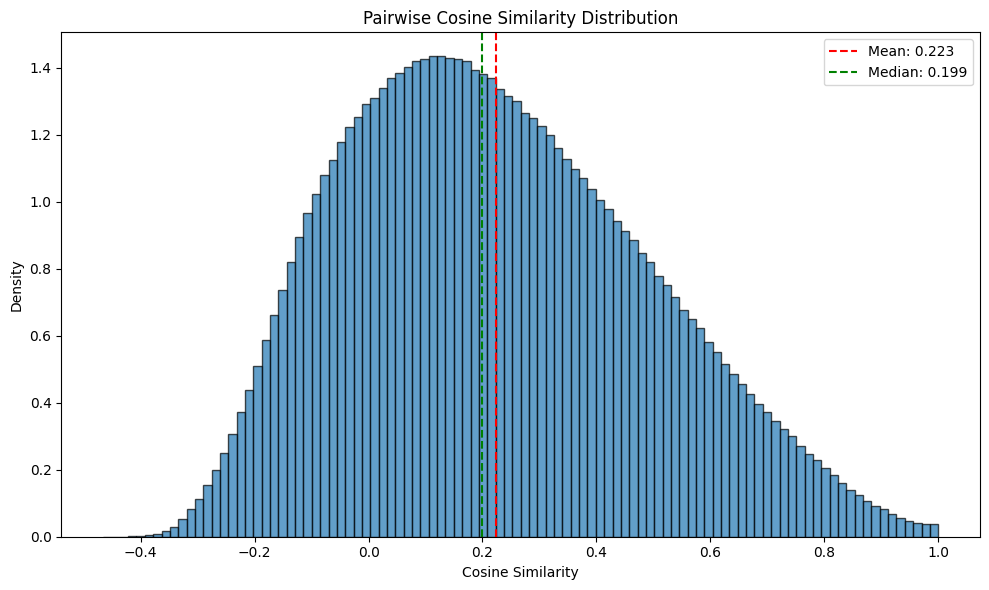

In [10]:
# Plot similarity distribution
fig = plot_similarity_distribution(
    embeddings, 
    title='Pairwise Cosine Similarity Distribution',
    sample_size=3000
)
plt.tight_layout()
plt.show()

## 6. Clustering Quality

Evaluate how well the embeddings can be clustered.

In [11]:
# Clustering quality analysis
print("Evaluating clustering quality...")
clustering_results = clustering_quality(
    embeddings, 
    n_clusters_range=[5, 10, 15, 20, 25, 30, 40, 50]
)

print(f"\nBest number of clusters: {clustering_results['best_n_clusters']}")
print(f"Best silhouette score: {clustering_results['best_silhouette']:.4f}")

Evaluating clustering quality...


Evaluating clustering: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]


Best number of clusters: 50
Best silhouette score: 0.1709


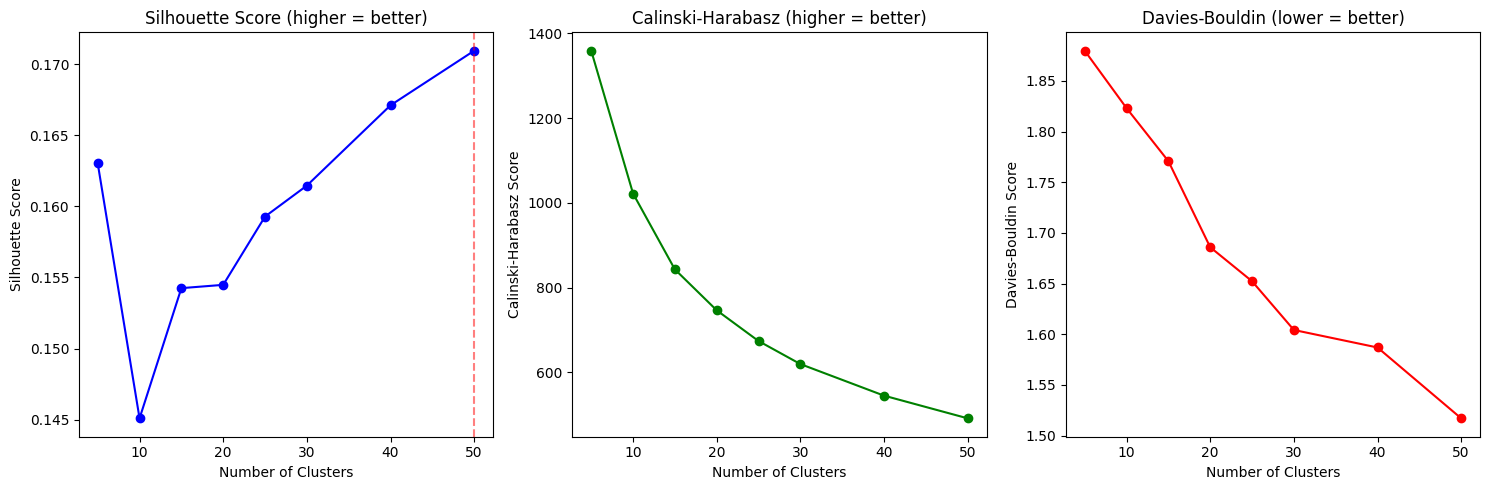

In [12]:
# Plot clustering metrics
fig = plot_clustering_metrics(clustering_results)
plt.tight_layout()
plt.show()

## 7. Nearest Neighbor Consistency

Test how stable the nearest neighbors are under different levels of augmentation noise.

In [13]:
# Nearest neighbor consistency (this may take a while)
# Use a smaller subset for faster computation
nn_sample_size = min(2000, len(sampled_paths))
nn_paths = sampled_paths[:nn_sample_size]
nn_dataset = GraphDataset(nn_paths)
nn_loader = DataLoader(nn_dataset, batch_size=256, shuffle=False)

print(f"Testing nearest neighbor consistency on {nn_sample_size} graphs...")
nn_results = nearest_neighbor_consistency(
    model,
    nn_loader,
    augment_graph,
    device=DEVICE,
    n_augmentations=3,
    k=10,
    noise_levels=[0.05, 0.08, 0.1, 0.15]
)

print("\n" + "="*50)
print("NEAREST NEIGHBOR CONSISTENCY")
print("="*50)
for key, value in nn_results.items():
    print(f"{key}: {value:.4f}")

Testing nearest neighbor consistency on 2000 graphs...


Computing original embeddings: 100%|██████████| 8/8 [00:00<00:00, 12.75it/s]



NEAREST NEIGHBOR CONSISTENCY
nn_consistency_noise_0.05: 0.9862
nn_consistency_std_noise_0.05: 0.0008
nn_consistency_noise_0.08: 0.9787
nn_consistency_std_noise_0.08: 0.0005
nn_consistency_noise_0.1: 0.9750
nn_consistency_std_noise_0.1: 0.0010
nn_consistency_noise_0.15: 0.9631
nn_consistency_std_noise_0.15: 0.0008


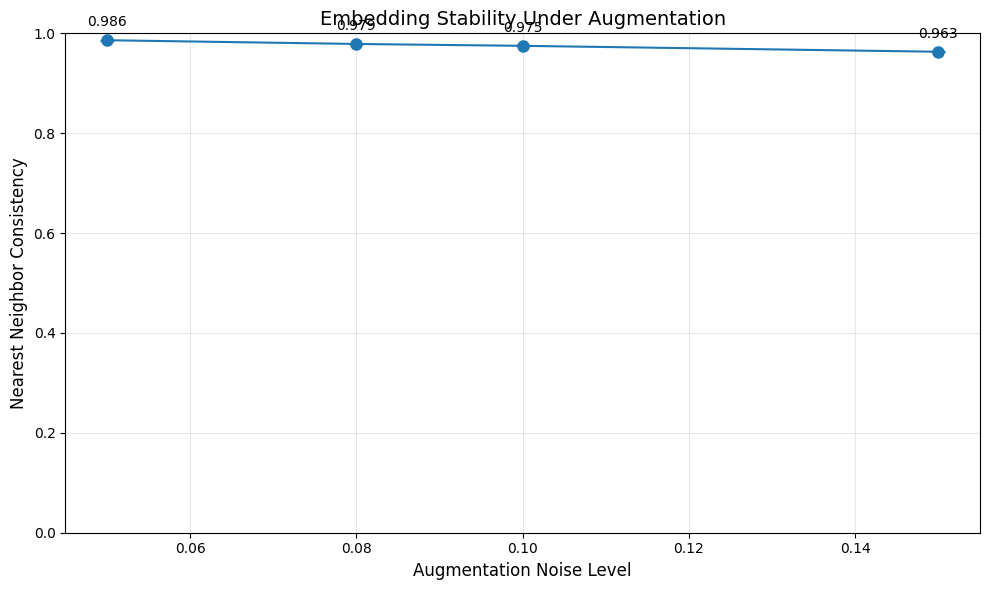

In [14]:
# Plot NN consistency across noise levels
noise_levels = [0.05, 0.08, 0.1, 0.15]
consistencies = [nn_results[f'nn_consistency_noise_{n}'] for n in noise_levels]
stds = [nn_results[f'nn_consistency_std_noise_{n}'] for n in noise_levels]

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(noise_levels, consistencies, yerr=stds, fmt='o-', capsize=5, markersize=8)
ax.set_xlabel('Augmentation Noise Level', fontsize=12)
ax.set_ylabel('Nearest Neighbor Consistency', fontsize=12)
ax.set_title('Embedding Stability Under Augmentation', fontsize=14)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

# Add annotations
for i, (noise, cons) in enumerate(zip(noise_levels, consistencies)):
    ax.annotate(f'{cons:.3f}', (noise, cons), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Embedding Visualization

Visualize the embedding space using t-SNE and PCA.

Computing t-SNE projection (this may take a minute)...


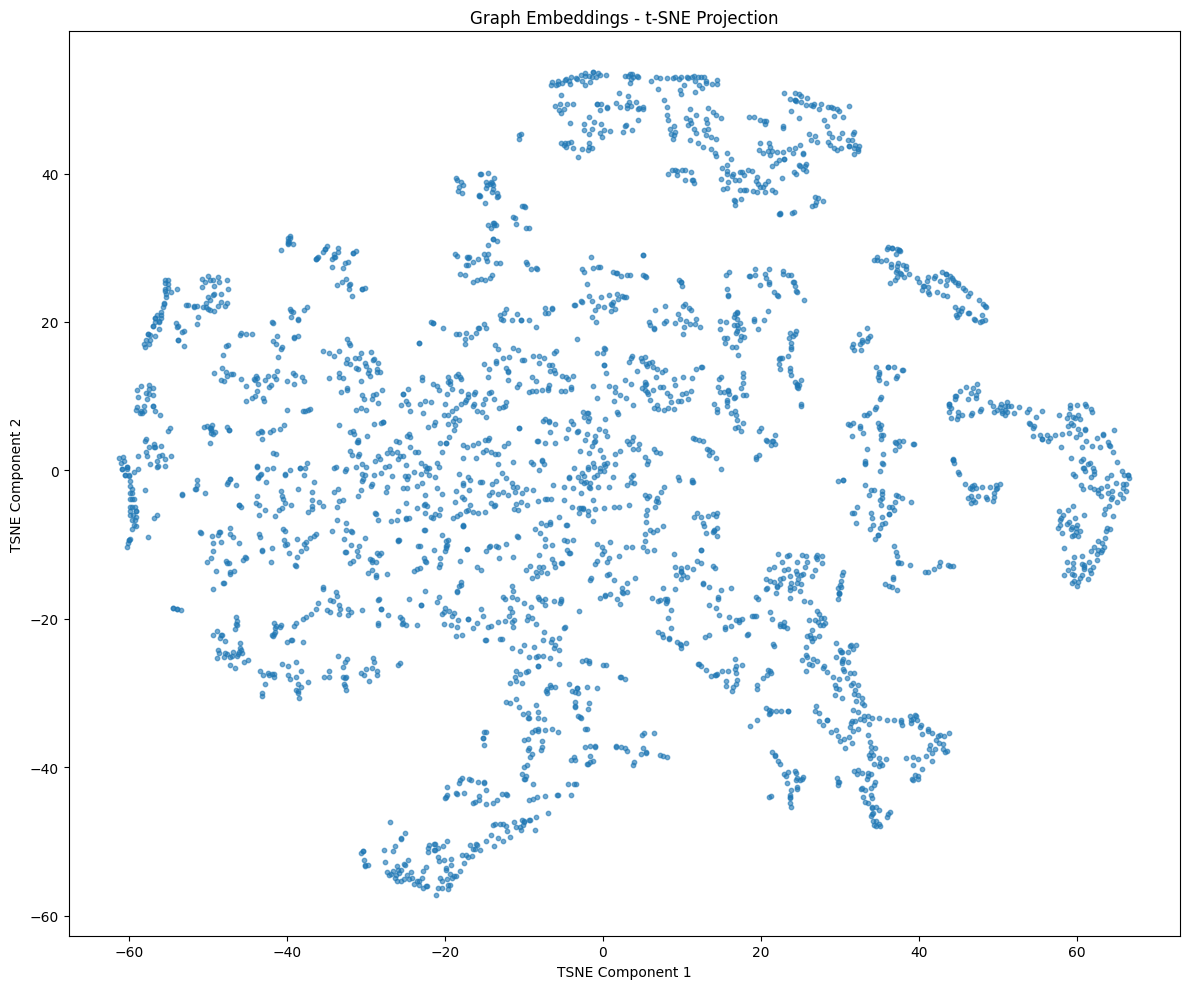

In [15]:
# t-SNE visualization
print("Computing t-SNE projection (this may take a minute)...")
fig = plot_embedding_visualization(
    embeddings,
    labels=None,  # Set to cluster labels if available
    method='tsne',
    title='Graph Embeddings - t-SNE Projection',
    sample_size=3000
)
plt.tight_layout()
plt.show()

Computing PCA projection...


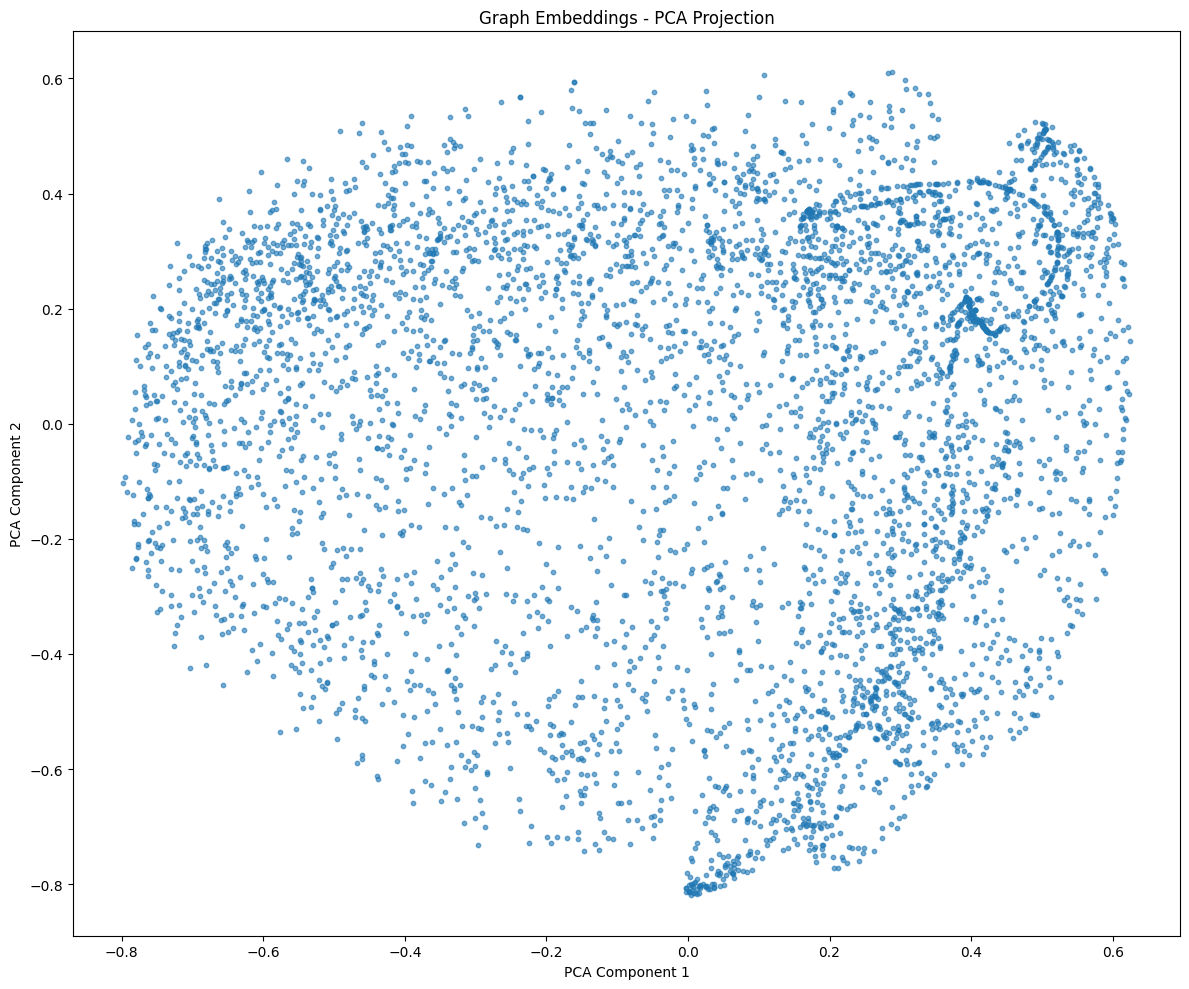

In [16]:
# PCA visualization
print("Computing PCA projection...")
fig = plot_embedding_visualization(
    embeddings,
    labels=None,
    method='pca',
    title='Graph Embeddings - PCA Projection',
    sample_size=5000
)
plt.tight_layout()
plt.show()

Clustering with k=50...


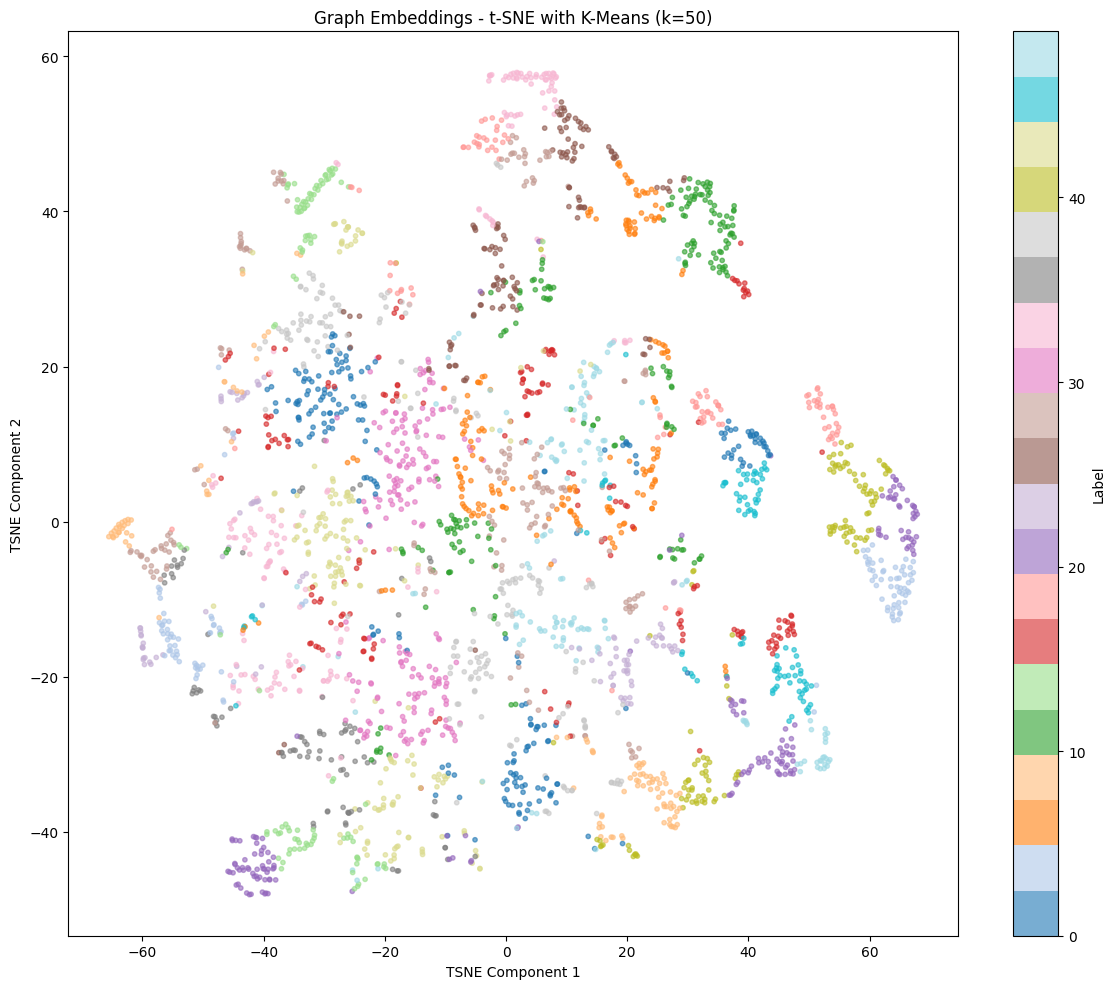

In [17]:
# Visualize with cluster labels from KMeans
from sklearn.cluster import KMeans

# Cluster embeddings
n_clusters = clustering_results['best_n_clusters']
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

print(f"Clustering with k={n_clusters}...")

# t-SNE with cluster colors
fig = plot_embedding_visualization(
    embeddings,
    labels=cluster_labels,
    method='tsne',
    title=f'Graph Embeddings - t-SNE with K-Means (k={n_clusters})',
    sample_size=3000
)
plt.tight_layout()
plt.show()

## 9. Summary Report

Generate a comprehensive summary of the embedding quality.

In [18]:
# Print comprehensive summary
print("\n" + "="*80)
print("EMBEDDING QUALITY EVALUATION SUMMARY")
print("="*80)
print(f"\nCheckpoint: {CHECKPOINT_PATH}")
print(f"Sample size: {len(embeddings)}")
print(f"Embedding dimension: {embeddings.shape[1]}")

print("\n--- Embedding Space Properties ---")
print(f"Mean cosine similarity: {space_analysis['mean_cosine_similarity']:.4f}")
print(f"Std cosine similarity: {space_analysis['std_cosine_similarity']:.4f}")
print(f"Effective dimensionality (95% var): {space_analysis['effective_dimensionality']}")
print(f"Uniformity (lower=better): {space_analysis['uniformity']:.4f}")

print("\n--- Clustering Quality ---")
print(f"Best silhouette score: {clustering_results['best_silhouette']:.4f}")
print(f"Optimal clusters: {clustering_results['best_n_clusters']}")

print("\n--- Nearest Neighbor Consistency ---")
for noise in [0.05, 0.08, 0.1, 0.15]:
    key = f'nn_consistency_noise_{noise}'
    if key in nn_results:
        print(f"Noise {noise}: {nn_results[key]:.4f} (+/- {nn_results[f'nn_consistency_std_noise_{noise}']:.4f})")

print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("""
- Mean cosine similarity: Should be moderate (0.2-0.6). Too high = collapsed embeddings.
- Effective dimensionality: Higher = more expressive embeddings.
- Uniformity: Lower = better use of embedding space.
- Silhouette score: Higher = better-defined clusters (-1 to 1, >0.3 is good).
- NN Consistency: Higher = more stable embeddings (0-1, >0.7 is good).
""")


EMBEDDING QUALITY EVALUATION SUMMARY

Checkpoint: /home/tmuehlen/repos/graph_coverage/checkpoints/20260106_222347/checkpoint_loop0_epoch0.pt
Sample size: 10000
Embedding dimension: 384

--- Embedding Space Properties ---
Mean cosine similarity: 0.2214
Std cosine similarity: 0.2630
Effective dimensionality (95% var): 18
Uniformity (lower=better): -2.5226

--- Clustering Quality ---
Best silhouette score: 0.1709
Optimal clusters: 50

--- Nearest Neighbor Consistency ---
Noise 0.05: 0.9862 (+/- 0.0008)
Noise 0.08: 0.9787 (+/- 0.0005)
Noise 0.1: 0.9750 (+/- 0.0010)
Noise 0.15: 0.9631 (+/- 0.0008)

INTERPRETATION GUIDE

- Mean cosine similarity: Should be moderate (0.2-0.6). Too high = collapsed embeddings.
- Effective dimensionality: Higher = more expressive embeddings.
- Uniformity: Lower = better use of embedding space.
- Silhouette score: Higher = better-defined clusters (-1 to 1, >0.3 is good).
- NN Consistency: Higher = more stable embeddings (0-1, >0.7 is good).



## 10. (Optional) Compare Multiple Models

Uncomment and run this section to compare different trained models.

In [ ]:
# # Uncomment to compare multiple models
# 
# CHECKPOINTS_TO_COMPARE = {
#     'model_1': 'checkpoints/run1/checkpoint.pt',
#     'model_2': 'checkpoints/run2/checkpoint.pt',
# }
# 
# # Load models
# models_dict = {}
# for name, path in CHECKPOINTS_TO_COMPARE.items():
#     full_path = str(PROJECT_ROOT / path)
#     model, _ = load_model_from_checkpoint(full_path, DEVICE)
#     models_dict[name] = model
# 
# # Compare
# comparison_results = compare_models(
#     models_dict,
#     eval_loader,
#     augment_graph,
#     device=DEVICE
# )
# 
# # Print summary
# print_comparison_summary(comparison_results)

In [ ]:
# Save results to file (optional)
import json

results_to_save = {
    'checkpoint': CHECKPOINT_PATH,
    'sample_size': len(embeddings),
    'embedding_dim': int(embeddings.shape[1]),
    'space_analysis': space_analysis,
    'clustering': {
        'best_n_clusters': clustering_results['best_n_clusters'],
        'best_silhouette': clustering_results['best_silhouette'],
    },
    'nn_consistency': nn_results,
}

# Save to checkpoint directory
if CHECKPOINT_PATH:
    output_path = Path(CHECKPOINT_PATH).parent / 'embedding_evaluation.json'
    with open(output_path, 'w') as f:
        json.dump(results_to_save, f, indent=2)
    print(f"Results saved to: {output_path}")